In [9]:
import jax.numpy as np
from jax import jit
from discopy import Tensor, Ty, Word, Cup, Id
Tensor.np = np

import discopy
import random

In [14]:
#******************************************
# Generate your corpus
#******************************************
# sentences can be of the `word1 word2 word3 ...`
# if you are generating the diagrams using templates
# then you may want to consider adding POS tags (N, V, Adj) for each word
# labels should be of the form [0,1] or [1,0] for binary classification

# Make sentences and labels
nouns = ["Alice", "Bob", "Charlie", "Diane", "Eve", "Fred", "George", "Isabel"]
verbs = ["hates", "hugs", "kills", "kisses", "likes", "loves"]

s, n = Ty('s'), Ty('n')
tv = n.r @ s @ n.l

vocab = [Word(noun, n) for noun in nouns] + [Word(verb, tv) for verb in verbs]

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentences = [
    "{} {} {}".format(subj, verb, obj)
    for subj in nouns for verb in verbs for obj in nouns]

print("Our total corpus has", len(sentences), "sentences")
random.shuffle(sentences)

labels=[]
for line in sentences:
    subj, verb, obj = line.split(' ')
    if verb == 'hates' or verb == 'kills':
        labels.append(0) #bad
    else:
        labels.append(1) #good 

# We define the number of samples used for training and validation (dev set) steps
# (remaining sentences end up being test set)

n_sentences= 10 # We keep a small set of sentences. To use full dataset: n_sentences= len(sentences) 
n_train=n_sentences//2
n_dev=n_sentences//5

print("Here we will use a set of", n_sentences, "sentences")

# We split our data (i.e, 'sentences' list)
train_sentences = sentences[:(n_train-1)]
dev_sentences = sentences[n_train:(n_dev-1)]
test_sentences = sentences[n_dev:]

# We also split the 'label' list
train_labels = labels[:(n_train-1)]
dev_labels = labels[n_train:(n_dev-1)]
test_labels = labels[n_dev:]

# We convert lists
train_labels = np.array(train_labels)
dev_labels = np.array(dev_labels)
test_labels = np.array(test_labels)

Our total corpus has 384 sentences
Here we will use a set of 10 sentences


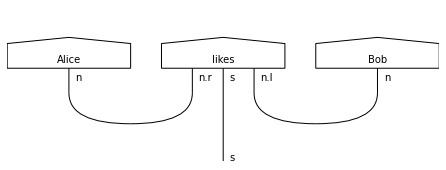

In [15]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

# Suggestion: print out some of your DisCoCat diagrams using
# `grammar.draw` to check that they make sense.

# TODO implement sentence2diagram
def sentence2diagram(sentence):
    subj, verb, obj = sentence.split(' ')
    diagram = Word(subj, n) @ Word(verb, tv) @ Word(obj, n) >> grammar
    return diagram

train_diagrams = [sentence2diagram(s) for s in train_sentences]
dev_diagrams = [sentence2diagram(s) for s in dev_sentences]
test_diagrams = [sentence2diagram(s) for s in test_sentences]

from discopy import Word, Ty, Cup, Id, grammar
from sympy.abc import phi

n, s = Ty('n'), Ty('s')

# example of how to make your template:
# then you use your pos tags to determine which template to use
def NVN_example(w0, w1, w2):
    words = Word(w0, n) @ Word(w1, n.r @ s @ n.l) @ Word(w2, n)
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    return words >> cups

grammar.draw(NVN_example('Alice', 'likes', 'Bob'))

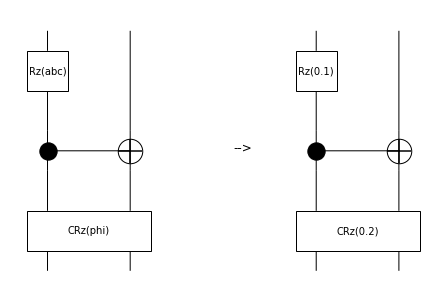

In [4]:
#******************************************
# Generate your circuits
#******************************************
# TODO: Implement your own functorial ansatz conversion!
# The `qnlp-tutorial` has some code on this.
# https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html
# You may also find discopy's `IQPansatz` function useful.

# Suggestion: Draw some DisCoCat diagrams alongside their circuit diagrams
# and compare them

# TODO implement diagram2circuit
def diagram2circuit(diagram):
    
    

train_circuits = [diagram2circuit(d) for d in train_diagrams]
dev_circuits = [diagram2circuit(d) for d in dev_diagrams]
test_circuits = [diagram2circuit(d) for d in test_diagrams]

# You can define parameterised circuits in DisCoPy
# using sympy variables, then substituting them using `lambdify`
from discopy import drawing
from discopy.quantum import Id, Rz, CX, CRz
from sympy.abc import symbols, phi


sym = symbols("abc")
circ = Rz(sym) @ Id(1) >> CX >> CRz(phi)
drawing.equation(circ, circ.lambdify(sym, phi)(0.1, 0.2), symbol='-->')

In [5]:
# These imports will come in handy when you want to run
# backend simulations.

# from qiskit import IBMQ
# from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend

In [6]:
#******************************************
# Counting parameters in your model
#******************************************
from sympy import default_sort_key
circuits = train_circuits + dev_circuits + test_circuits

# Make sure you sort your symbols as they are returned as a set.
parameters = sorted({
    s for circ in circuits for s in circ.free_symbols
}, key=default_sort_key)

In [7]:
def normalise(predicts):
    # apply smoothing to predicts
    predicts = np.abs(predicts - 1e-9)
    predicts = predicts / predicts.sum()
    return predicts

def BCE_loss(predicts, labels):
    cross_entropies = np.sum(labels * np.log2(predicts))
    cost = -1/len(labels) * np.sum(cross_entropies)

    return cost

In [8]:
def make_pred_fn(circuits):
    def pred_fn(params):
        predictions = np.array([
            normalise(np.abs(c.lambdify(*parameters)(*params).eval().array))
            for c in circuits
        ])
        return predictions

    return pred_fn

In [9]:
noisyopttrain_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = jit(make_pred_fn(test_circuits))

import numpy as onp
# onp.random.seed(0)

x0 = np.array(onp.random.random(len(parameters)))
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)
dev_pred_fn(x0)

Performing Just-In-Time compilation, this may take a while...


DeviceArray([], dtype=float32)

In [10]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [13]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions

train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs, callback_params = make_cost_fn(dev_pred_fn, dev_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [14]:
from noisyopt import minimizeSPSA
minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=2000, callback=dev_cost_fn)

ZeroDivisionError: division by zero

In [ ]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(dev_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Development Set')

ax2 = ax1.twinx()
ax2.plot(dev_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
plt.show()

In [ ]:
# when you are happy with the development set results
# run your model on the testing set

# for p in callback_params:
#     test_cost_fn(p)

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#7C83FD')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Testing Set')

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#96BAFF')
ax2.set_ylabel('Accuracy')
plt.show()